Copyright @ 2021 ABCOM Information Systems Pvt. Ltd. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and limitations under the License.


# Hyper-Parameter Tuning using Optuna


To install Optuna library execute pip install optuna 

In [ ]:
pip install optuna

     |████████████████████████████████| 296kB 4.0MB/s 
     |████████████████████████████████| 174kB 20.7MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 112kB 17.4MB/s 
     |████████████████████████████████| 143kB 17.4MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=74df016a36e4cc46483d4e87908612496f5c46061d5eb7f243769bcd13e3a5e2
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


### Required packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.svm import SVR
import optuna as op
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

### Fetching dataset


In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/abcom-mltutorials/Optuna/main/CCPP.csv")

df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE) of the plant.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


### Feature and Target Selection


In [ ]:
X=df.drop("PE",axis=1)
Y=df.PE

### Splitting Dataset


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=123)

In [ ]:
print("train: ",X_train.shape)
print("test: ",X_test.shape)

train:  (7654, 4)
test:  (1914, 4)


### Baseline Model

First we will create a model without any parameter tuning to understand effect of parameter tuning at the later stage

In [ ]:
model=SVR()
model.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#### Model accuracy

In [ ]:
model.score(X_test,y_test)

0.38922787580732543

### Optuna Hyperparameter Tuning

In this section we will try to maximize our accuracy using different hyperparameter tunning available for SVM model. 

Tuning parameters of SVM:

1. Kernel - Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’.
2. C - Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
3. degree - Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
4. gamma - Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.


In [ ]:
def objective(trial):
    kernel=trial.suggest_categorical('kernel',['rbf','poly','linear','sigmoid'])
    c=trial.suggest_float("C",0.1,3.0,log=True)
    gamma=trial.suggest_categorical('gamma',['auto','scale'])
    degree=trial.suggest_int("degree",1,3,log=True)
    model =SVR(kernel=kernel,degree=degree,gamma=gamma,C=c)
    model.fit(X_train,y_train)
    accuracy = model.score(X_test,y_test)
    return accuracy

In [ ]:
#optuna study record
study = op.create_study(direction="maximize")
study.optimize(objective, n_trials=20,n_jobs=-1)

[I 2022-04-01 04:59:26,470] A new study created in memory with name: no-name-0f8953a2-09e5-495a-addd-3457634fb07e
[I 2022-04-01 04:59:28,876] Trial 1 finished with value: -0.033889012046907974 and parameters: {'kernel': 'sigmoid', 'C': 0.9323530683705877, 'gamma': 'auto', 'degree': 1}. Best is trial 1 with value: -0.033889012046907974.
[I 2022-04-01 04:59:37,225] Trial 2 finished with value: 0.92986037518757 and parameters: {'kernel': 'linear', 'C': 0.39578756023480366, 'gamma': 'scale', 'degree': 2}. Best is trial 2 with value: 0.92986037518757.
[I 2022-04-01 04:59:39,656] Trial 3 finished with value: -0.033889012046907974 and parameters: {'kernel': 'sigmoid', 'C': 0.8885150104183361, 'gamma': 'auto', 'degree': 1}. Best is trial 2 with value: 0.92986037518757.
[I 2022-04-01 04:59:43,541] Trial 4 finished with value: 0.9298981757594549 and parameters: {'kernel': 'poly', 'C': 0.2495024523902746, 'gamma': 'auto', 'degree': 1}. Best is trial 4 with value: 0.9298981757594549.
[I 2022-04-01

### Best result



In [ ]:
trial=study.best_trial
print("Best Tuning Parameters : {} \n with accuracy of : {:.2f} %".format(trial.params,trial.value))

Best Tuning Parameters : {'kernel': 'linear', 'C': 0.10540821019812002, 'gamma': 'auto', 'degree': 1} 
 with accuracy of : 0.92 %


### tuning Model

now we will use the obtained best parameter from the Optuna operation for fitting the model.

In [ ]:
#model with the return parameters
model_tunned=SVR(kernel='linear',
                C= 0.10540821019812002,
                gamma='auto',
                degree=1)
model_tunned.fit(X_train,y_train)

SVR(C=0.10540821019812002, cache_size=200, coef0=0.0, degree=1, epsilon=0.1,
    gamma='auto', kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False)

### Accuracy


In [ ]:
print(model_tunned.score(X_test,y_test))

0.9223965517337869


### Study Plot of Optuna

The visualization module of optuna provides utility for plotting the optimization process using plotly and matplotlib. Plotting functions generally take a Study object and optional parameters are passed as a list to the params argument.

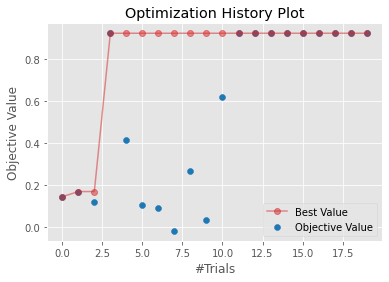

In [ ]:
op.visualization.matplotlib.plot_optimization_history(study)

Plot optimization history of all trials in a study.

The line plot indicates the best accuracy in complete trial run amongst all and  blue indicates individual trial accuracy.

## References:

* [Optuna: A hyperparameter optimization framework](https://optuna.readthedocs.io/en/stable/)

* [GitHub - optuna](https://github.com/optuna/optuna)